# Exploratory Data Analysis (EDA) on Customer Loans in Finance

This notebook will focus on the EDA of the financial loans dataset, the dataset will be:
1) loaded in as a pandas DataFrame.

2) DataFrame will be transformed using various techniques.
    - removing **nulls**
    - assessing and transforming **skew**
    - assessing and removing **outliers**
    - assessing **correlation**
    
3) Visual plots to show the data and how it is affected.

## Necessary Imports

In [1]:
from db_utils import loading_data
from data_transform import DataTransform
from data_frame_info import DataFrameInfo
from data_frame_transform import DataFrameTransform
from plotter import Plotter

## Loading in the Dataset

The financial loan dataset is loaded in using the loading_data function to produce a pandas DataFrame.

In [2]:
financial_loan_df = loading_data()

A copy of the financial_loan_df DataFrame is made as original_df for a visual plot comapring the original DataFrame to a Transformed DataFrame.

In [3]:
original_df = financial_loan_df.copy()

## Transforming the DataFrame

The DataFrame is transformed so the columns are set to their correct dtypes.
For example, categorical columns containing categorical data are set to 'category' dtype.

In [4]:
transformed_df = DataTransform(financial_loan_df).transform()

## Getting Information from the DataFrame

Using the DataFrameInfo class, we can access all types of information about the DataFrame, from the columns dtype to the number of null values present in each column.

In [5]:
DataFrameInfo(transformed_df).null_value_count(as_percentage=True)

id                              0.000000
member_id                       0.000000
loan_amount                     0.000000
funded_amount                   5.544799
funded_amount_inv               0.000000
term                            8.799395
int_rate                        9.531449
instalment                      0.000000
grade                           0.000000
sub_grade                       0.000000
employment_length               3.905515
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_date                      0.000000
loan_status                     0.000000
payment_plan                    0.000000
purpose                         0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_credit_line            0.000000
inq_last_6mths                  0.000000
mths_since_last_delinq         57.166565
mths_since_last_record         88.602460
open_accounts   

From this output we can see a number of columns have null values, some being large and some only missing a small percentage of values. 

## Handling Nulls

The columns with a percentage of nulls above a threshold of 10% will be removed from the DataFrame. This is because too much data is missing and so imputing the data will cause bias amongst the results.

Then the remaining columns with a percentage of nulls below 10% will be imputed with either their median or mean for numerical columns (depending on their skew) or their mode for categorical columns.

In [6]:
transformations = DataFrameTransform(transformed_df, threshold=0.1)

In [7]:
transformations.drop_high_null_columns()
visual_plot_df = transformed_df.copy()

In [8]:
imputed_df = transformations.impute_missing_values()

The DataFrame is now saved as a new CSV file for later use in other analysis where the data will not be affected by the skew and outlier transformations.

In [9]:
imputed_df.to_csv('transformed_financial_loan_data.csv', index=False)

We could now re-run the null_value_count method to check the percentage of null values have all decreased to zero, however, instead this can be visualised in a barplot comparing the percentage of nulls present before and after the transformations.

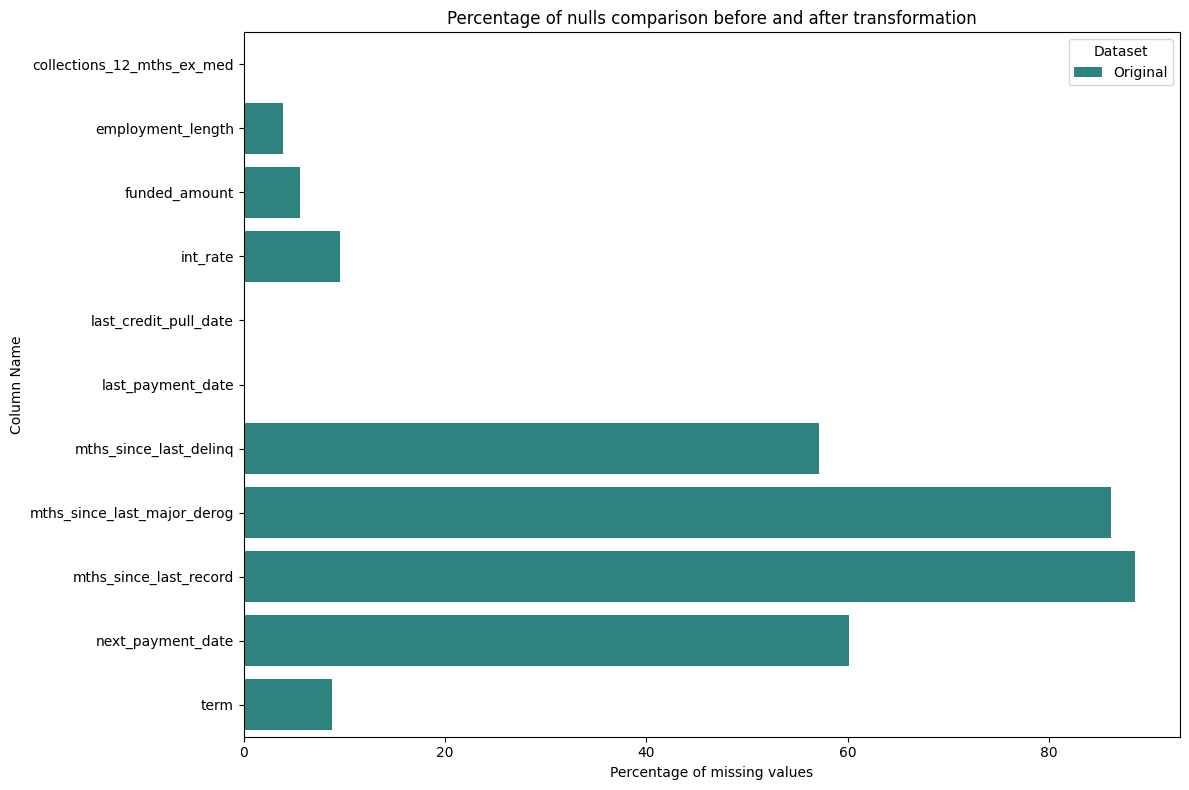

In [10]:
Plotter(imputed_df).removal_of_null_visualised(original_df)


The following plot is to compare the null percentage of the columns that have had data imputed and have not been dropped from the DataFrame.

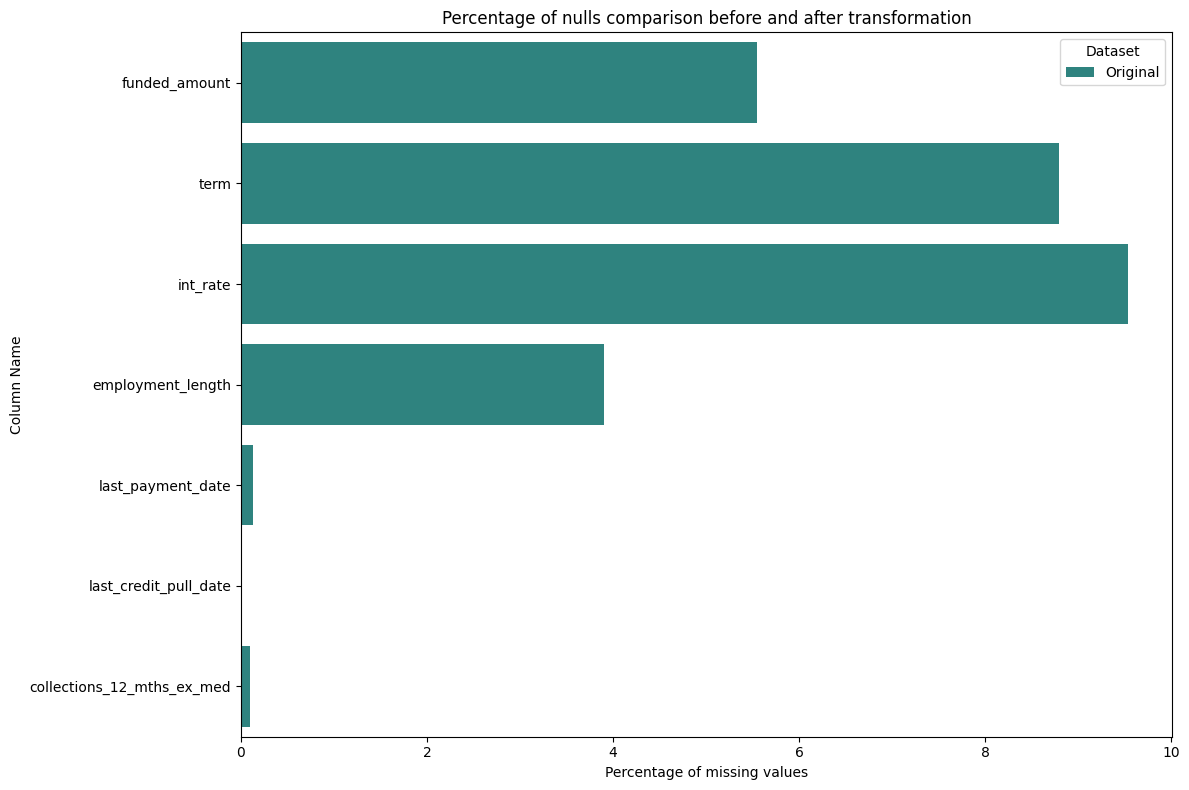

In [11]:
Plotter(imputed_df).removal_of_null_visualised(visual_plot_df)

## Analysing the Skew of columns

I will now analyse the skew present in the dataset for each column. I will visualise the skew in each column using a FacetGrid to show the distribution. I will then transform the skewed columns and then revisualise the skew using a FacetGrid.

In [12]:
skew_analysis = DataFrameInfo(imputed_df)
skewed_columns = skew_analysis.skew_check(threshold=1)

In [13]:
plot_visual_analysis = Plotter(imputed_df)

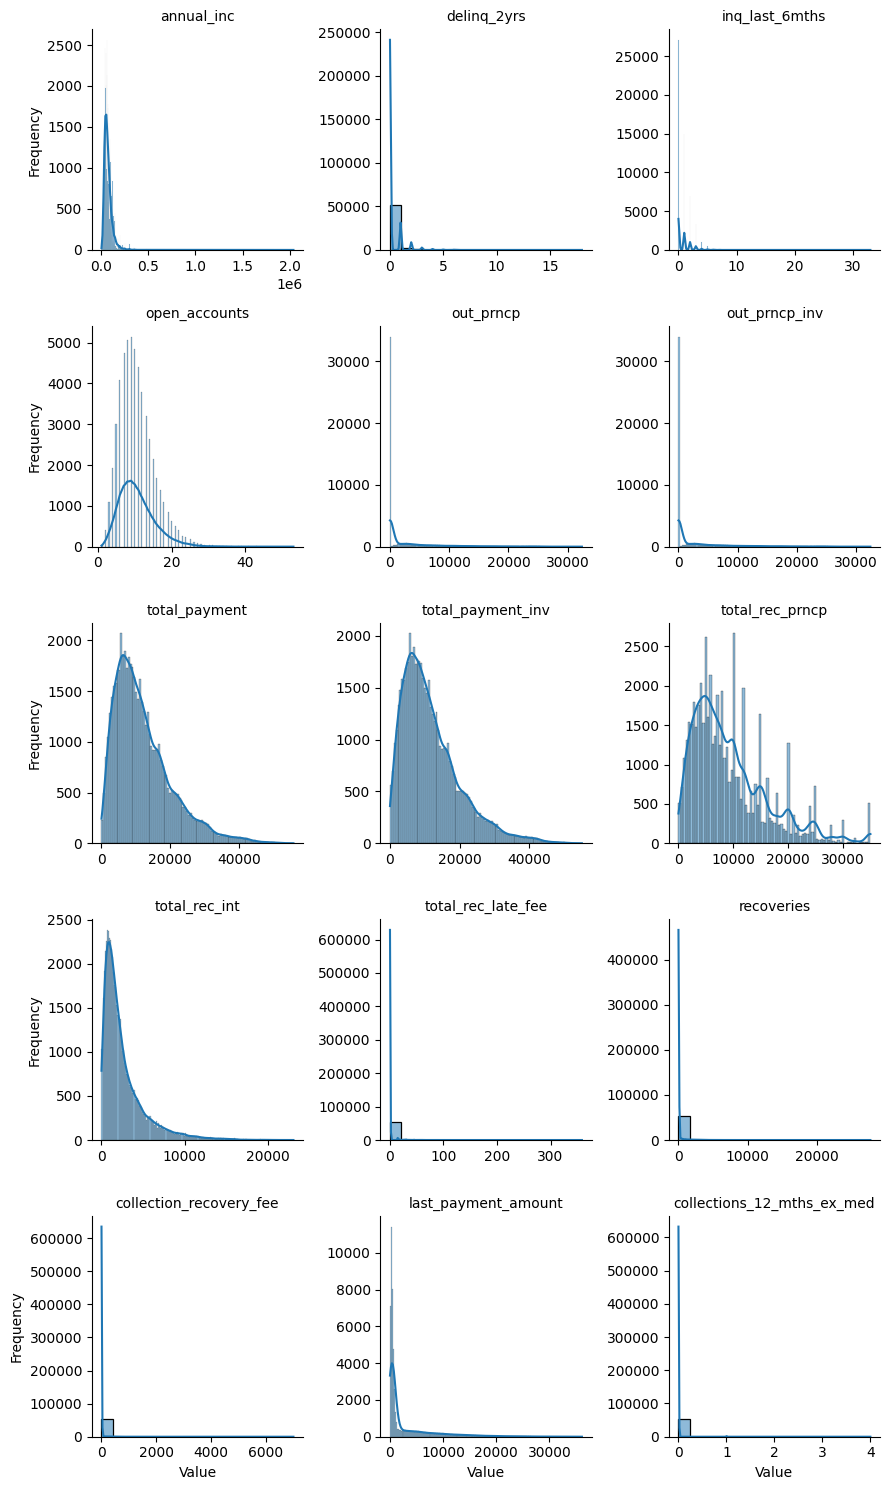

In [14]:
plot_visual_analysis.skew_plotted(skewed_columns)

From this FacetGrid plot we can see multiple columns have a right-positive skew. To correct the skew on the skewed columns in the DataFrame, a skew transformation will be applied across the columns that have a skew above 1 (or below -1) to correct this skew.

In [15]:
skewed_df = DataFrameTransform(imputed_df).best_transform_skewed_columns(skewed_columns)

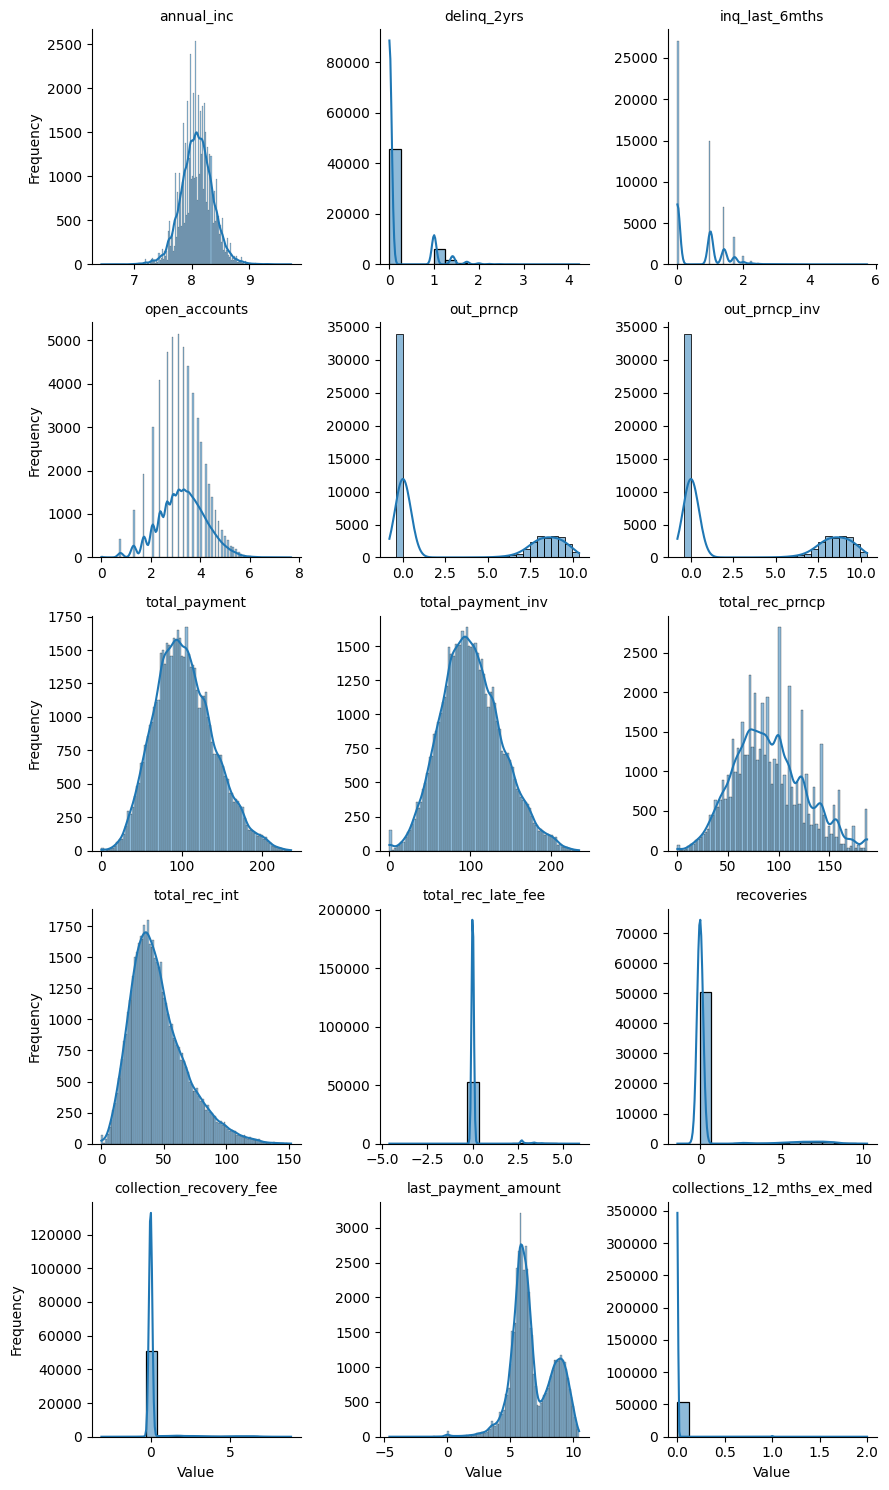

In [16]:
plot_visual_analysis.skew_plotted(skewed_columns)

The skewed columns have now been transformed by one of three methods: logarithmic transformation, square root transformation or a box-cox transformation. This is decided on which transformation results in the best skew correctness for the column. As we can see from the FacetGrid, the columns skew have significantly decreased and the data is now ready to be assessed for outliers and correlation.

## Handling Outliers 

Removing outliers from the dataset will improve the quality and accuracy of the analysis as outliers can distort the analysis results.
First I will visualise each numerical column in a box plot to identify where the outliers are in each column.

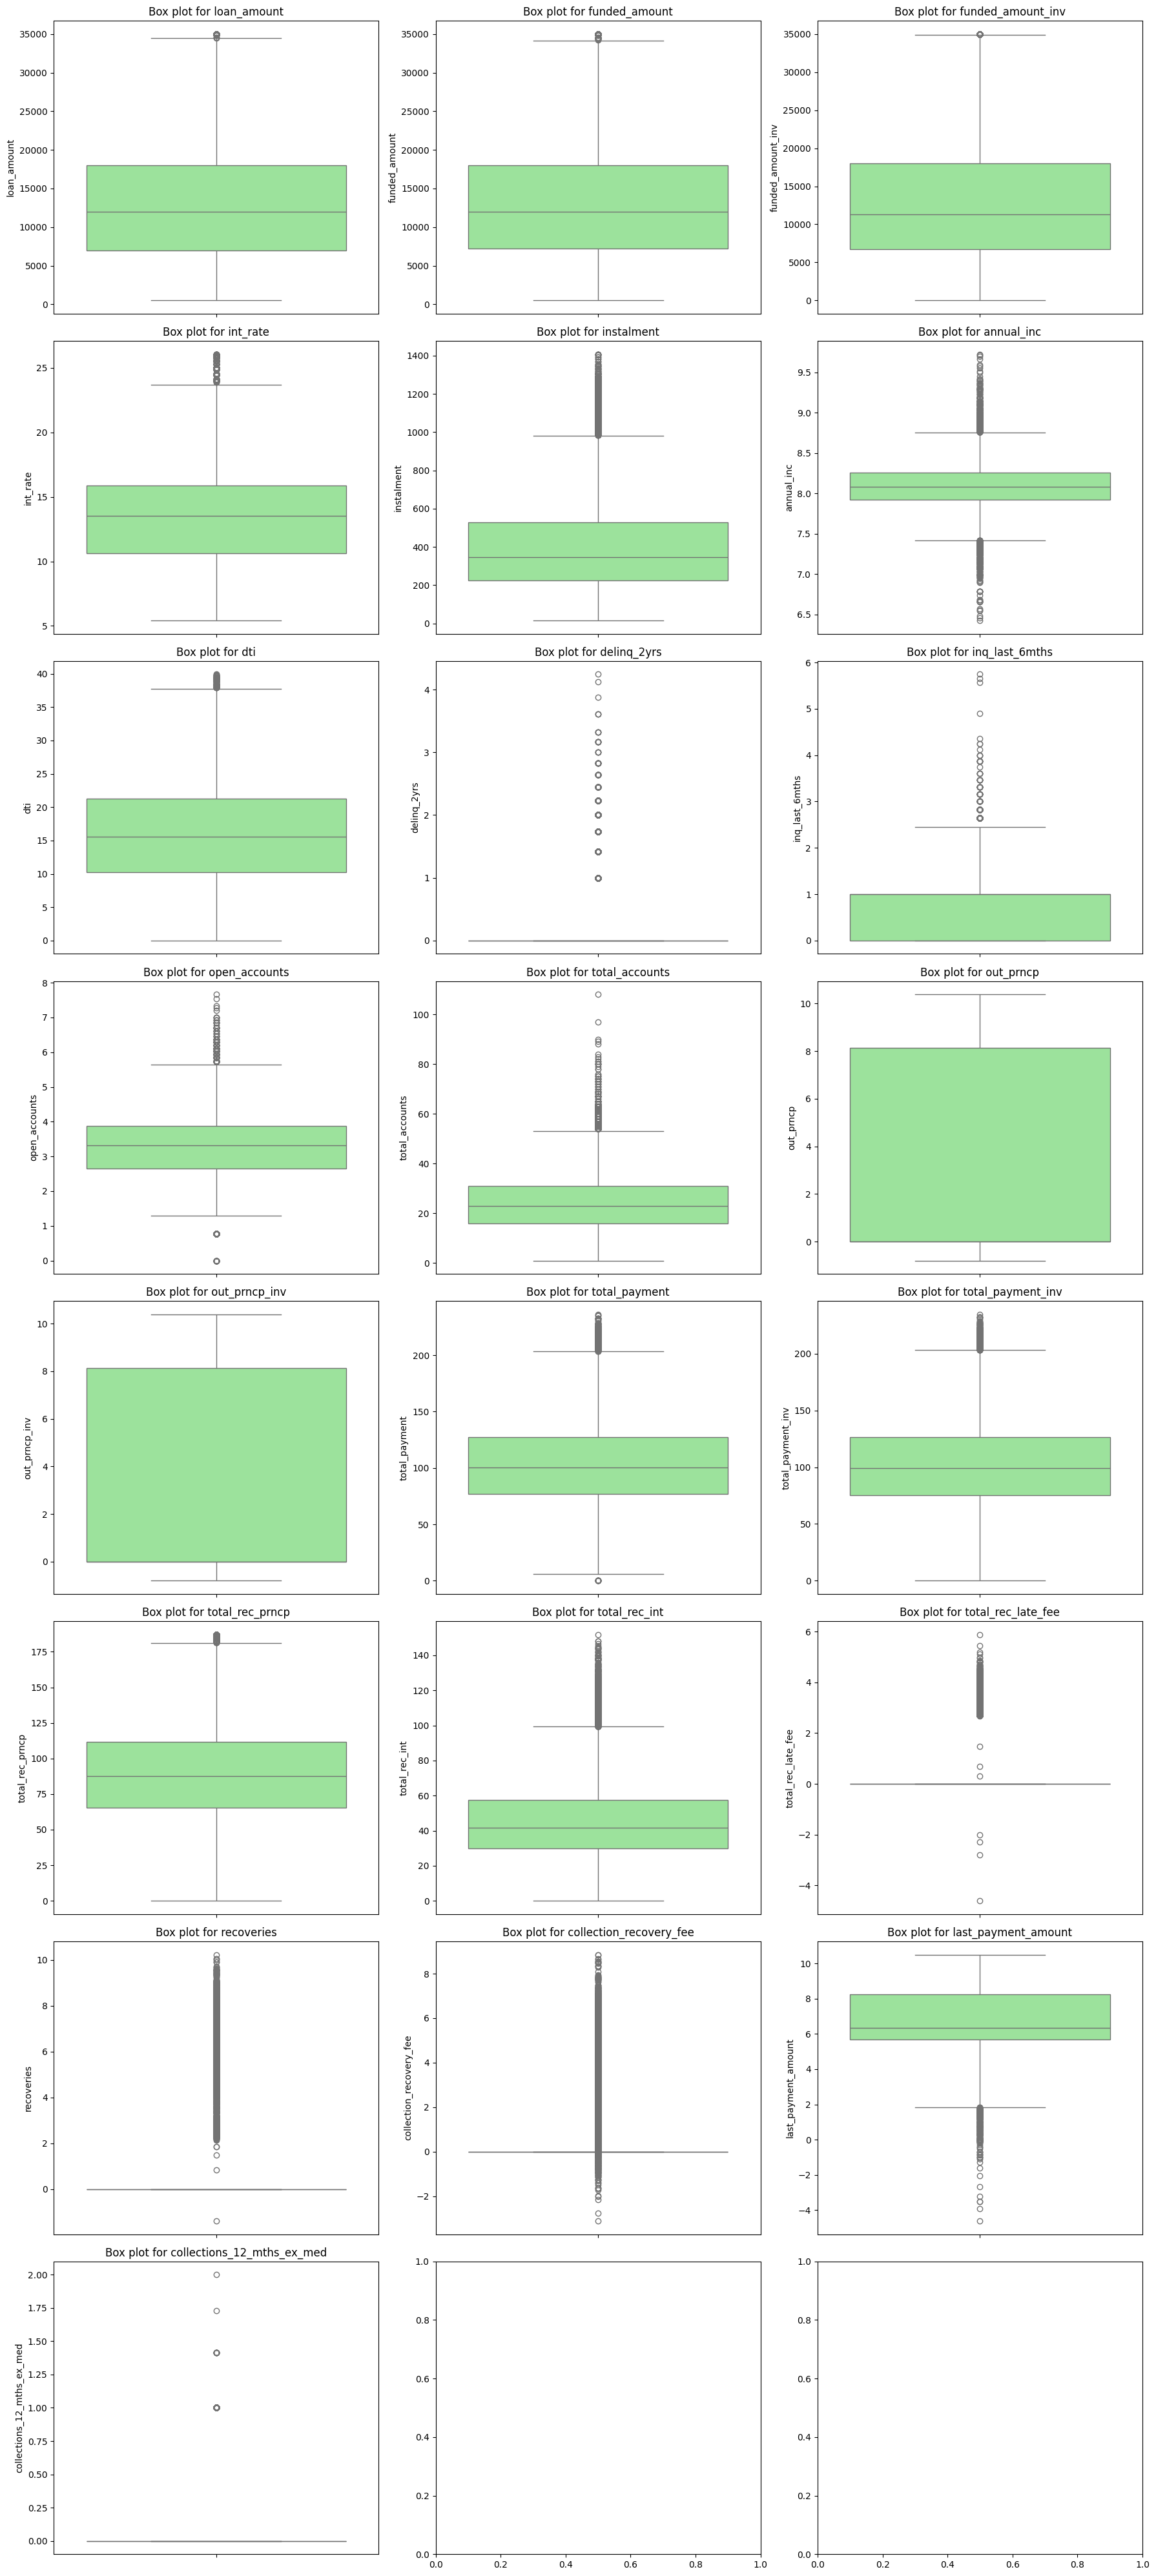

In [17]:
plot_visual_analysis.view_outliers(cols=3)

From this graph we can see multiple columns seem to have outliers, but in reality, are actually data points because the vast majority of data will have 0 in this column.

To correct this we will re-plot the plot excluding these columns:
- 'delinq_2yrs'
- 'total_rec_late_fee'
- 'recoveries'
- 'collection_recovery_fee'
- 'collection_12mths_ex_med'
- 'inq_last_6mths'

In [18]:
columns_with_outliers = [
    'loan_amount', 'funded_amount', 'funded_amount_inv', 'int_rate',
    'instalment', 'annual_inc', 'dti','open_accounts', 'total_accounts',
    'total_payment', 'total_payment_inv', 'total_rec_prncp',
    'total_rec_int', 'last_payment_amount',
    ]

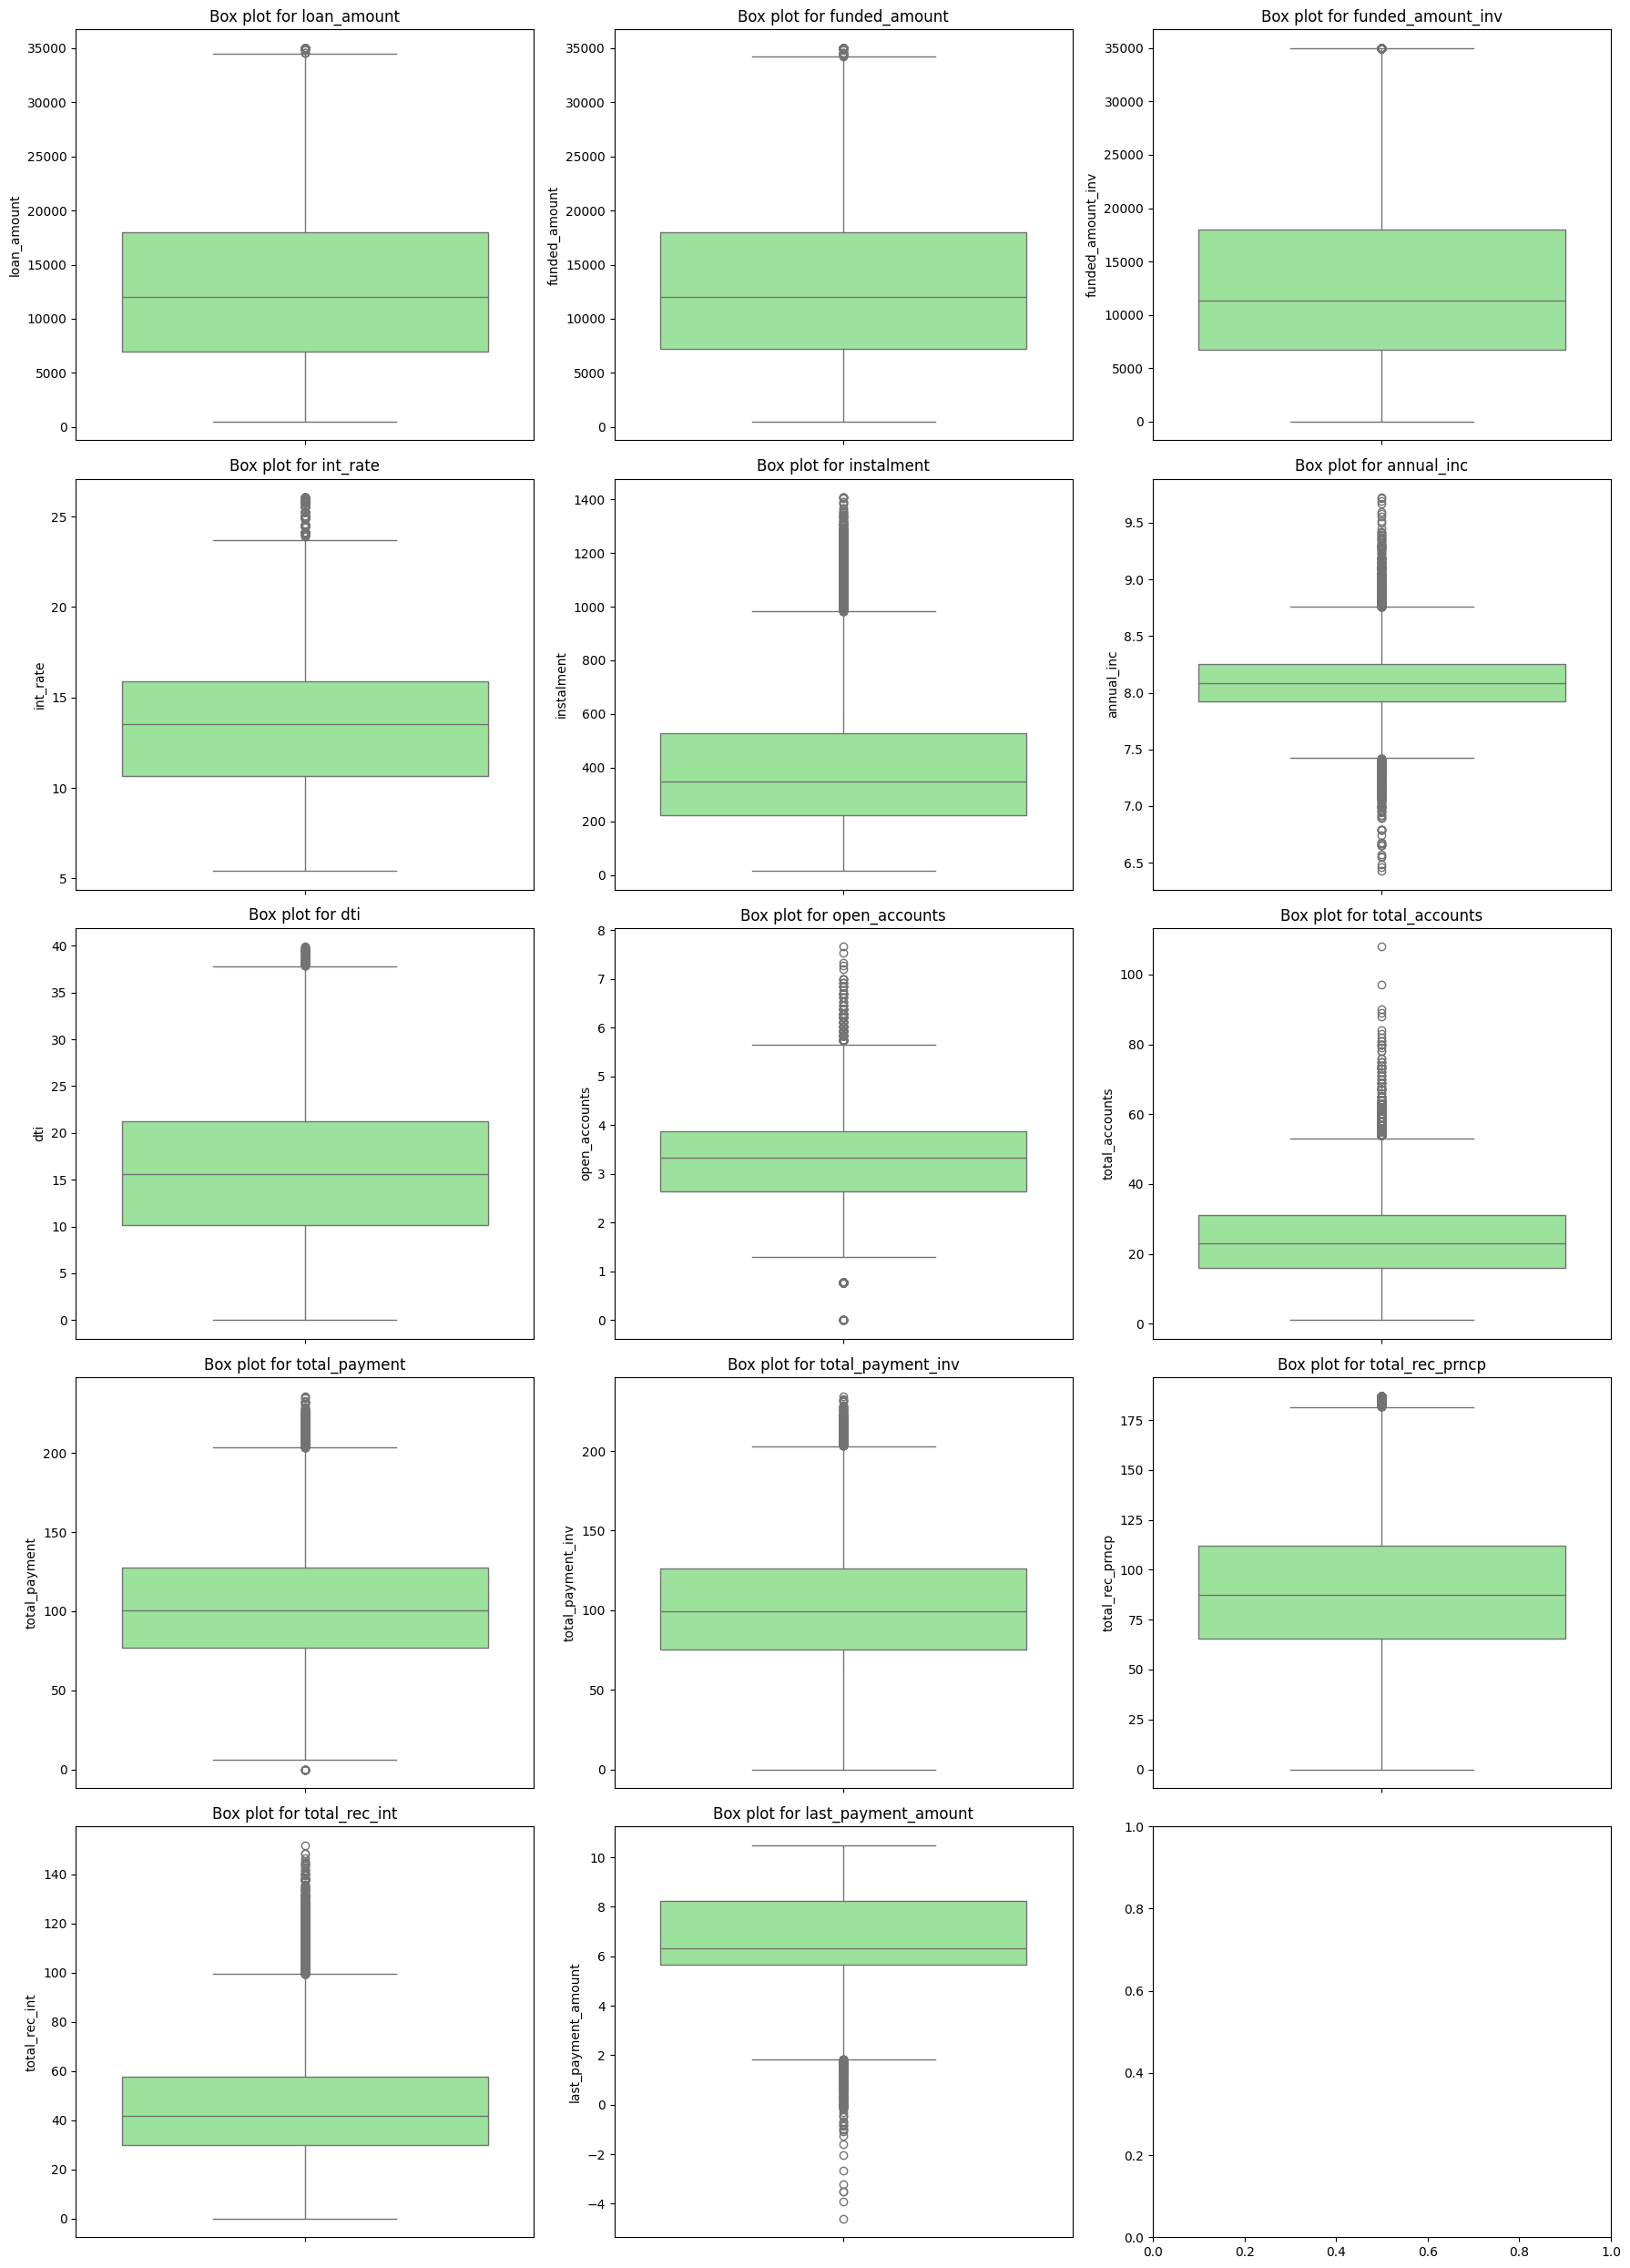

In [19]:
plot_visual_analysis.view_outliers(columns=columns_with_outliers, cols=3)

The outliers will now be removed using the Interquartile Range (IQR) method. All outliers will be removed and I will then re-visualise the box plots for each column.

In [20]:
outlier_df = DataFrameTransform(imputed_df).remove_outliers(columns=columns_with_outliers, threshold=1.5)

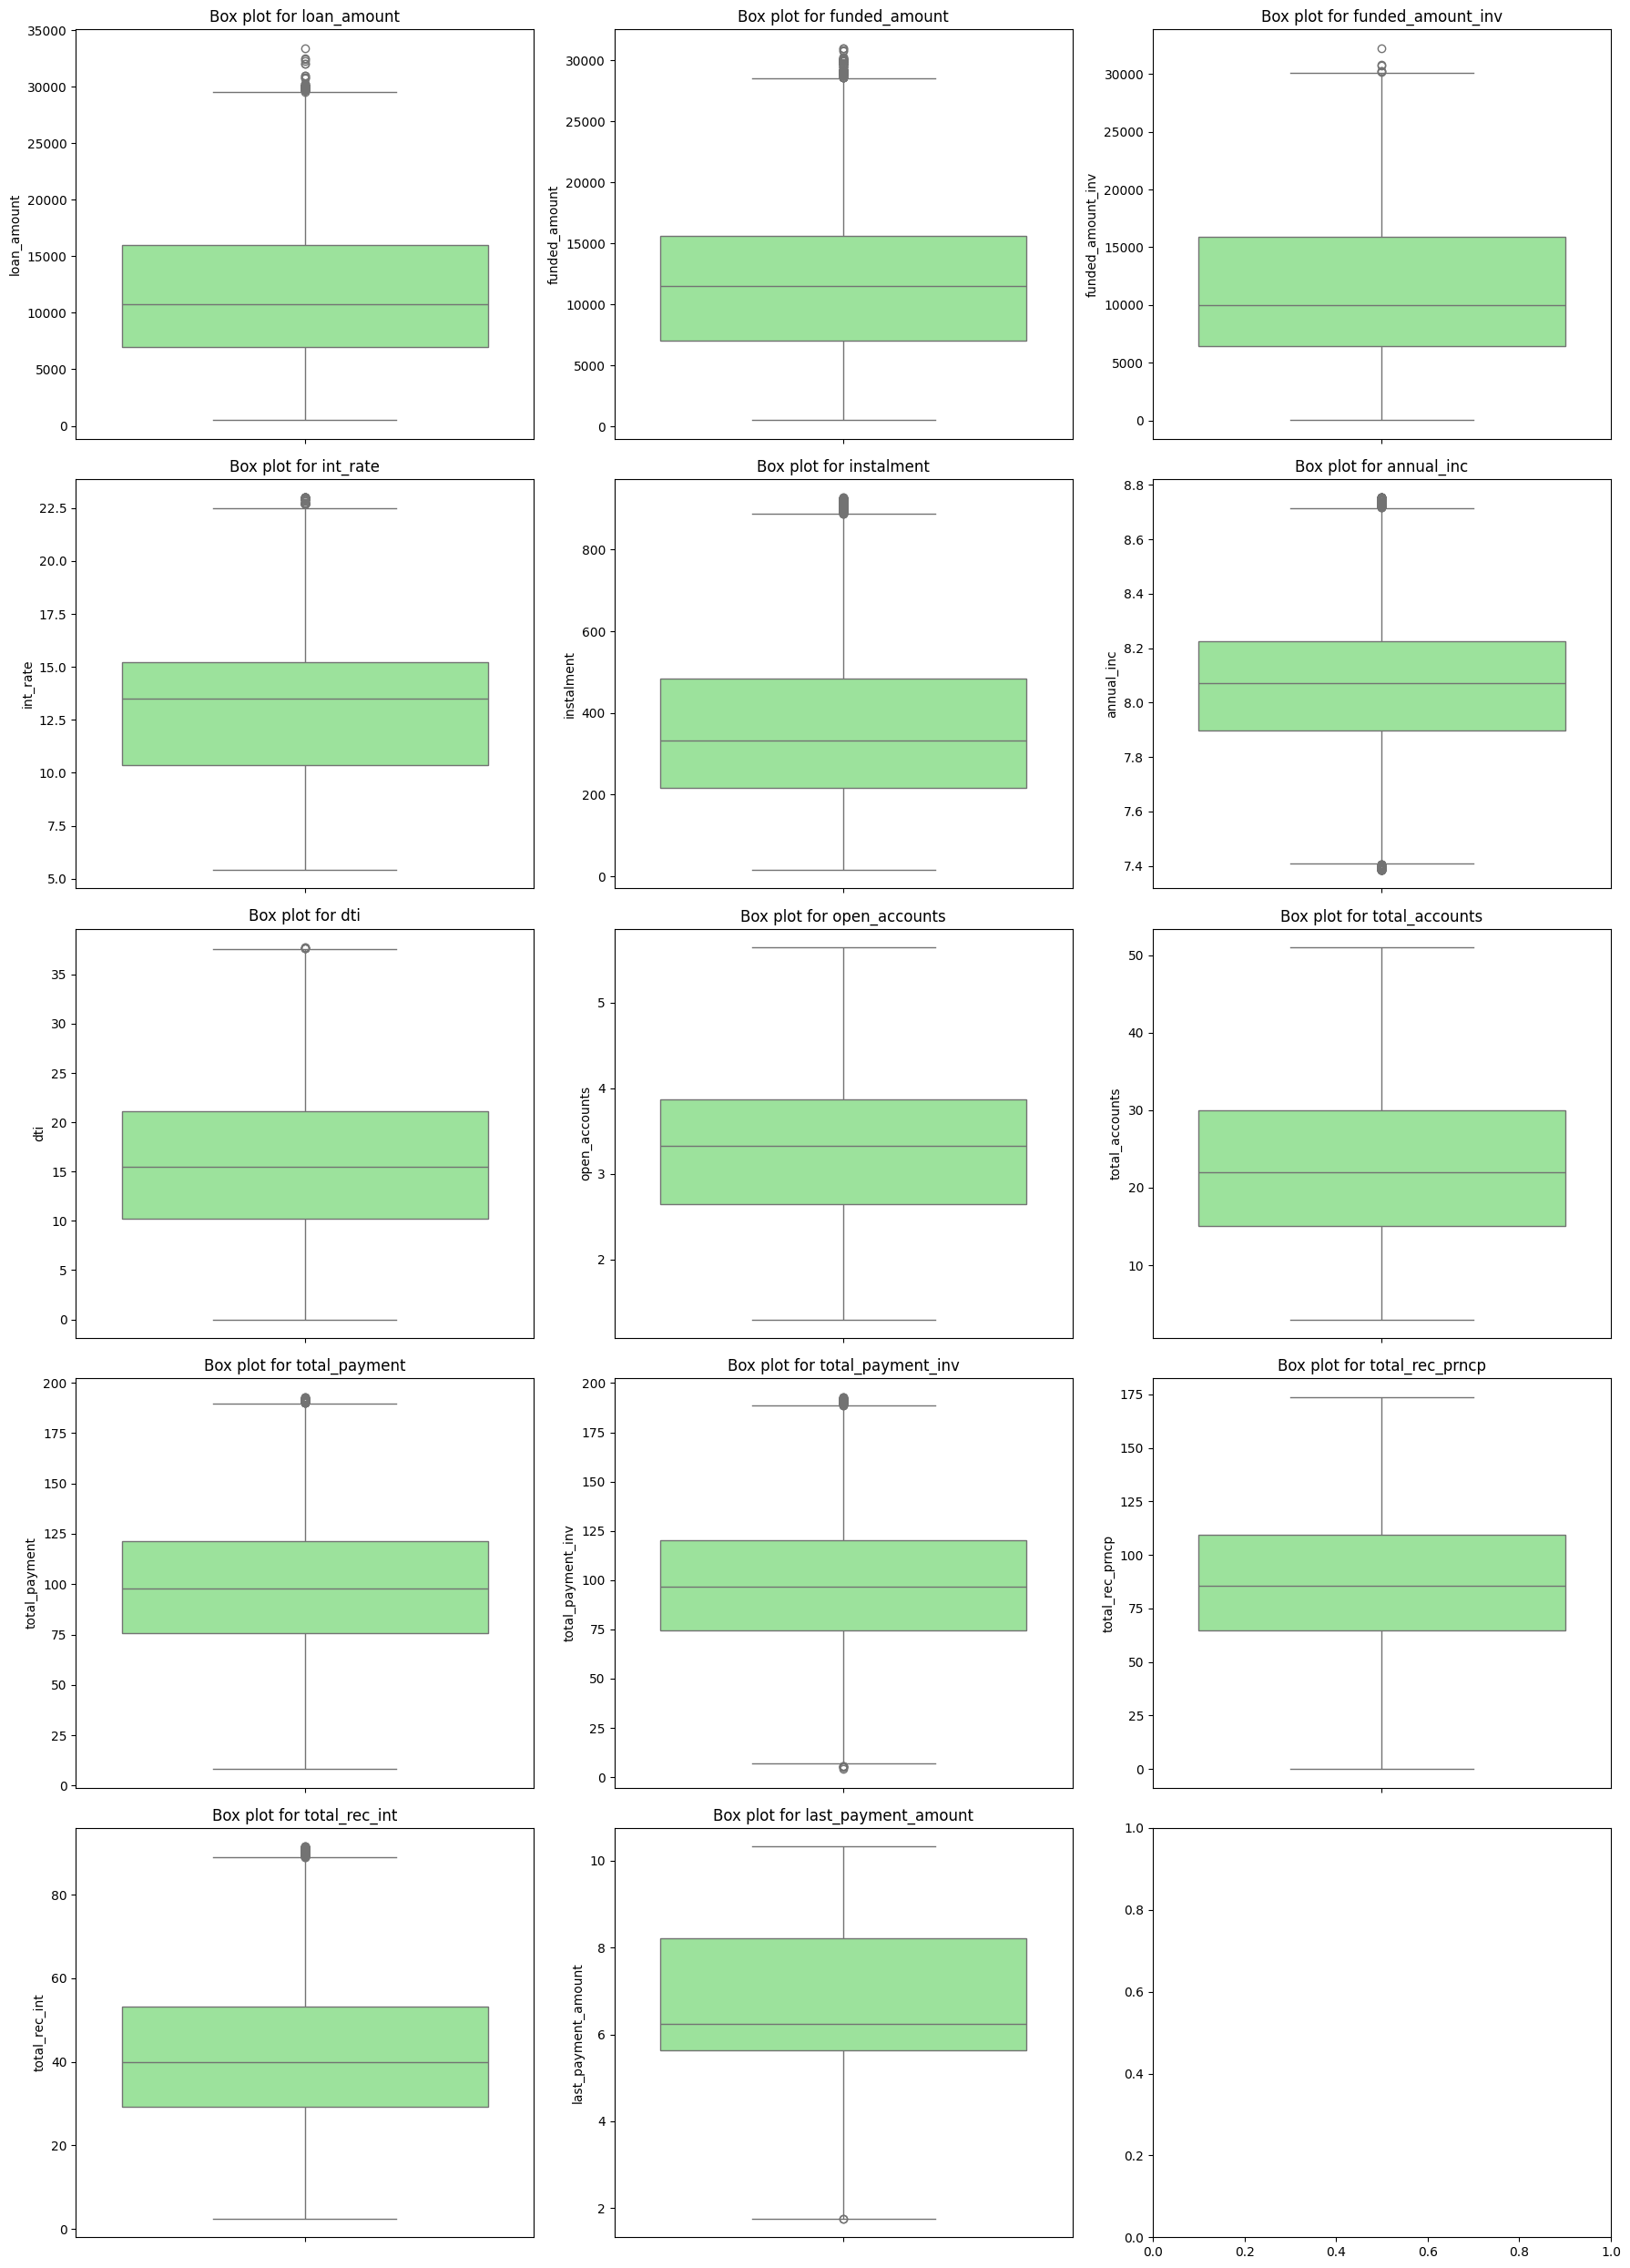

In [21]:
Plotter(outlier_df).view_outliers(columns=columns_with_outliers, cols=3)

## Correlation between columns

Highly correlated columns in a dataset can lead to multicollinearity issues, which can affect the accuracy and interpretability of models built on the data. I will plot a Correlation Matrix to visualise columns that are highly correlated.

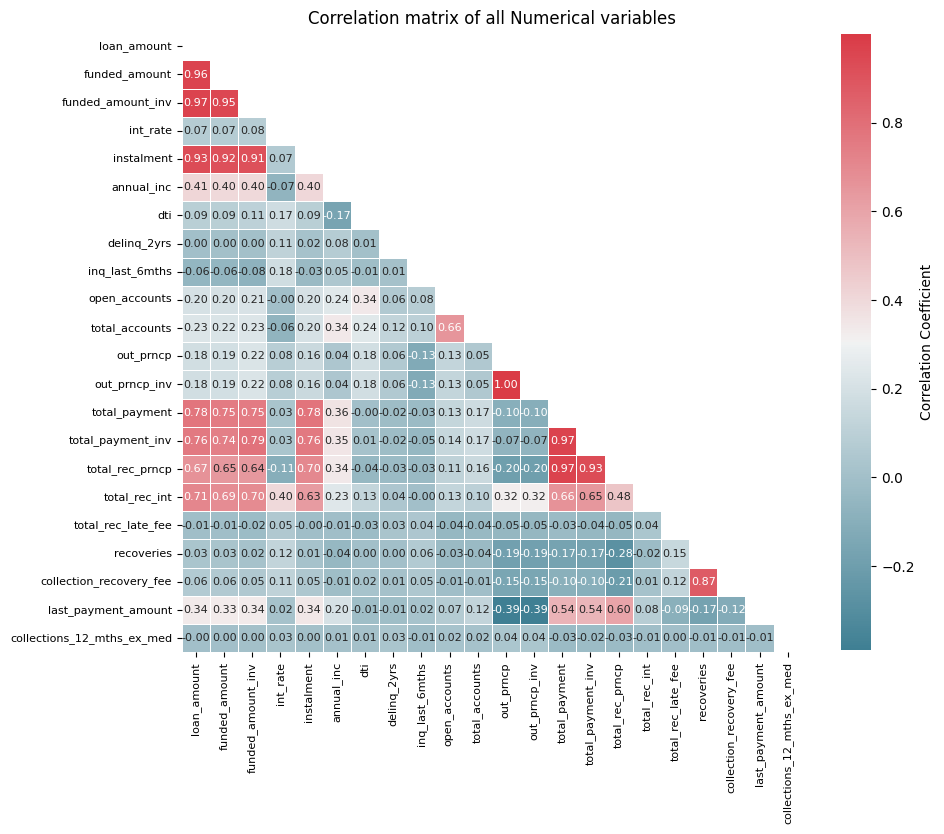

In [22]:
Plotter(outlier_df).view_correlation()

From the correlation matrix we can see mutliple columns seem to have too high a correlation (over 0.8) and therefore will be classed as colinear and will need to be removed. These columns are:

- 'funded_amount' 
- 'funded_amount_inv'
- 'instalment'
- 'out_prncp_inv' 
- 'total_payment_inv'
- 'total_rec_prncp'
- 'collection_recovery_fee'

In [23]:
highly_correlated = ['funded_amount', 'funded_amount_inv', 'instalment',
                    'out_prncp_inv', 'total_payment_inv', 'total_rec_prncp', 
                    'collection_recovery_fee']

In [24]:
correlated_rm_df = DataFrameTransform(outlier_df).remove_high_correlation_columns(highly_correlated)

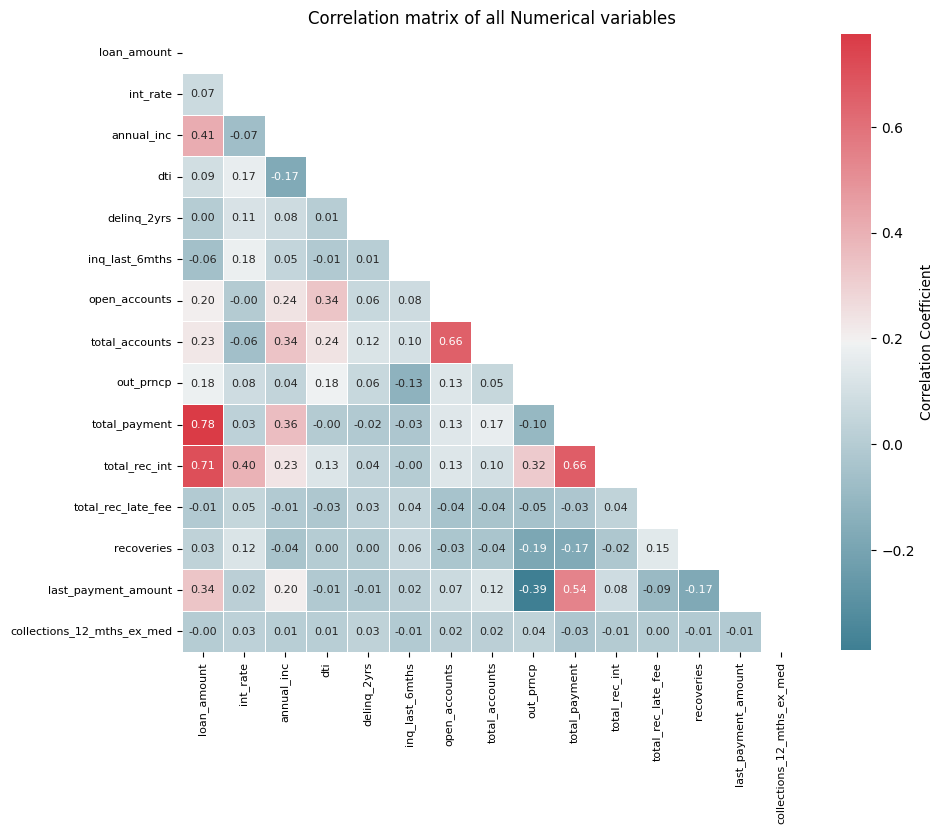

In [25]:
Plotter(correlated_rm_df).view_correlation()

We can now see from the correlation matrix that no columns correlate above the 0.8 threshold and are therefore classed as appropriate to be included. 

## EDA Analysis Results

**Data Quality Assessment:**
- Identified and handled missing values, outliers, and duplicates.
- Verified data types, inconsistencies, and anomalies.

**Visualisation of Data:**
- Developed charts (scatter plots, histograms, box plots, heatmaps, etc.) to identify relationships between variables.
- Detected underlying trends and potential predictors for further analysis.

**Prepared Dataset for Modeling:**
- Cleaned and transformed data into a format ready for machine learning or statistical modeling.

The dataset is now ready for deeper analysis, predictive modeling, and actionable business strategies.